# Fuzzy Logic Irrigation Control Systems

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1yAN8-U4PYYpOpNwnDTreGdBmlVWGl4eu)

## Overview
Implementation of fuzzy logic-based irrigation control systems using scikit-fuzzy:
1. **Basic System**: Weather-based irrigation control
2. **Advanced System**: Multi-parameter environmental control

## Contributors
- Abolfazl Ranjbar - [GitHub](https://github.com/ImRanjbar)
- Miaad Kimiagari - [GitHub](https://github.com/Miaad2004)
- Taha Najaf - [GitHub](https://github.com/taha-najaf)

## Objectives
- Design fuzzy membership functions and rule bases
- Implement intelligent irrigation decision systems
- Compare defuzzification methods
- Simulate temporal irrigation behavior

## Technologies
- **scikit-fuzzy**: Fuzzy logic framework
- **NumPy/Matplotlib**: Computation and visualization

## Library Setup

Required dependencies for fuzzy logic implementation.

In [ ]:
!pip -q install ipywidgets

try:
  import skfuzzy as fuzz

except:
  !pip -q install scikit-fuzzy

finally:
  import skfuzzy as fuzz

import numpy as np
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.7 MB/s eta 0:00:00


# Part 1: Basic Fuzzy Irrigation System

## System Architecture
Basic fuzzy control system with one-hot encoded weather conditions.

**Inputs**: Soil moisture (0-100%), Weather states (sunny/cloudy/rainy)  
**Output**: Irrigation amount (0-100)  
**Method**: Triangular/trapezoidal membership functions with rule-based inference

## Fuzzy Variable Definitions

Membership function definitions for system inputs and outputs.

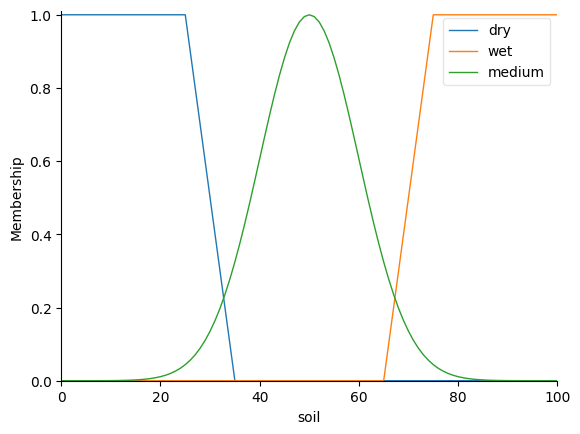

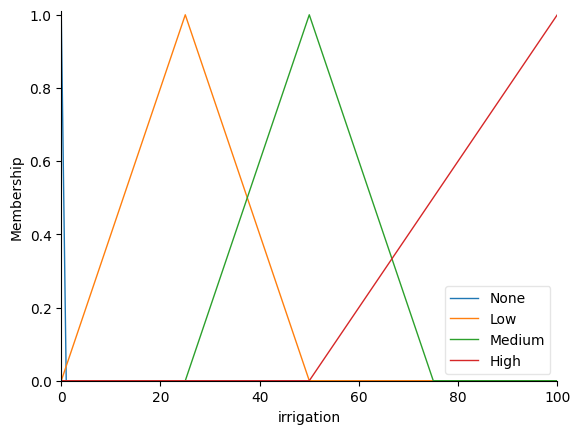

In [ ]:
# DEFINE FUZZY VARIABLES

# Antecedent: soil moisture (0–100)
soil = ctrl.Antecedent(np.arange(0, 101, 1), 'soil')

soil['dry']    = fuzz.trapmf(soil.universe, [0, 0, 25, 35])
soil['wet']    = fuzz.trapmf(soil.universe, [65, 75, 100, 100])
soil['medium'] = fuzz.gaussmf(soil.universe, 50, 10)

sunny  = ctrl.Antecedent([0, 1], 'sunny')
cloudy = ctrl.Antecedent([0, 1], 'cloudy')
rainy  = ctrl.Antecedent([0, 1], 'rainy')

# Membership: exactly 0→False, 1→True
for var in (sunny, cloudy, rainy):
    var['False'] = fuzz.trimf(var.universe, [0, 0, 1])
    var['True']  = fuzz.trimf(var.universe, [0, 1, 1])

# Consequent: irrigation amount (0–100)
irrig = ctrl.Consequent(np.arange(0, 101, 1), 'irrigation')
irrig['None']   = fuzz.trimf(irrig.universe, [0,   0, 0])
irrig['Low']    = fuzz.trimf(irrig.universe, [0,  25, 50])
irrig['Medium'] = fuzz.trimf(irrig.universe, [25, 50, 75])
irrig['High']   = fuzz.trimf(irrig.universe, [50,100,100])

soil.view()
irrig.view()

## Rule Base Definition

IF-THEN rules mapping soil moisture and weather conditions to irrigation decisions.

In [ ]:
# BUILD RULES (one-hot weather encoding)

rules = [
    ctrl.Rule(soil['dry']    & sunny['True'],   irrig['High']),
    ctrl.Rule(soil['dry']    & cloudy['True'],  irrig['Medium']),
    ctrl.Rule(soil['dry']    & rainy['True'],   irrig['Low']),

    ctrl.Rule(soil['medium'] & sunny['True'],   irrig['Medium']),
    ctrl.Rule(soil['medium'] & cloudy['True'],  irrig['Low']),
    ctrl.Rule(soil['medium'] & rainy['True'],   irrig['None']),

    ctrl.Rule(soil['wet']    & sunny['True'],   irrig['Low']),
    ctrl.Rule(soil['wet']    & cloudy['True'],  irrig['None']),
    ctrl.Rule(soil['wet']    & rainy['True'],   irrig['None']),
]


## Control System Implementation

Fuzzy control system instantiation and simulation setup.

In [ ]:
# 3) CONTROL SYSTEM & SIMULATOR

system = ctrl.ControlSystem(rules)
sim    = ctrl.ControlSystemSimulation(system)

## System Testing

Fuzzy inference testing with defuzzification visualization.

Crisp irrigation for 30% & Sunny → 74.02


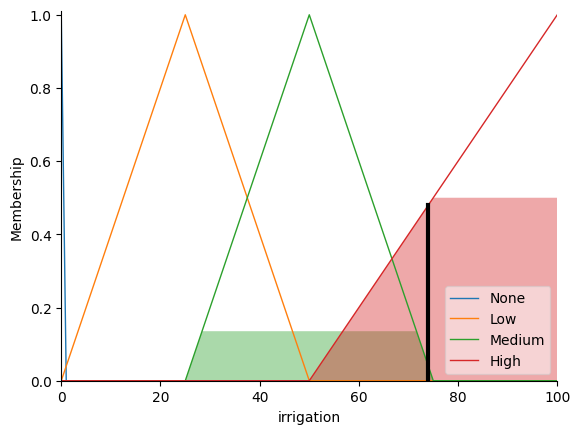

In [ ]:
# 4) DEFUZZIFY & PLOT ONE OUTPUT (one-hot weather version)

def compute_irrigation(soil_val, weather_label):
    # Clear out any previous inputs/state
    sim.reset()

    # Set the soil moisture
    sim.input['soil'] = soil_val

    # One-hot encode weather
    sim.input['sunny']  = 1 if weather_label == 'Sunny'  else 0
    sim.input['cloudy'] = 1 if weather_label == 'Cloudy' else 0
    sim.input['rainy']  = 1 if weather_label == 'Rainy'  else 0

    # Run the fuzzy inference + defuzzification
    sim.compute()

    # Return the crisp irrigation amount plus the sim (for plotting)
    return sim.output['irrigation'], sim

# Example usage
soil_val    = 30
weather_val = 'Sunny'

crisp, sim_state = compute_irrigation(soil_val, weather_val)
print(f"Crisp irrigation for {soil_val}% & {weather_val} → {crisp:.2f}")

# plot aggregated output with centroid
irrig.view(sim=sim_state)
plt.show()

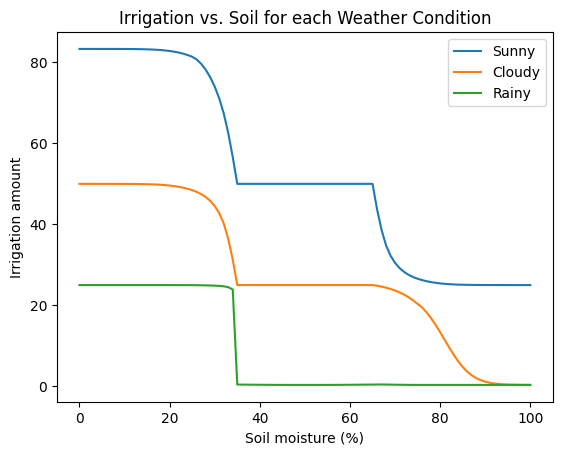

In [ ]:
# soil_range: 0–100 in steps of 1
soils = np.arange(0, 101, 1)

# collect outputs
out_sunny  = [compute_irrigation(s, 'Sunny')[0]  for s in soils]
out_cloudy = [compute_irrigation(s, 'Cloudy')[0] for s in soils]
out_rainy  = [compute_irrigation(s, 'Rainy')[0]  for s in soils]

plt.plot(soils, out_sunny,  label='Sunny')
plt.plot(soils, out_cloudy, label='Cloudy')
plt.plot(soils, out_rainy,  label='Rainy')
plt.xlabel('Soil moisture (%)')
plt.ylabel('Irrigation amount')
plt.legend()
plt.title('Irrigation vs. Soil for each Weather Condition')
plt.show()


### System Behavior Analysis

Irrigation response curves across soil moisture levels for different weather conditions.

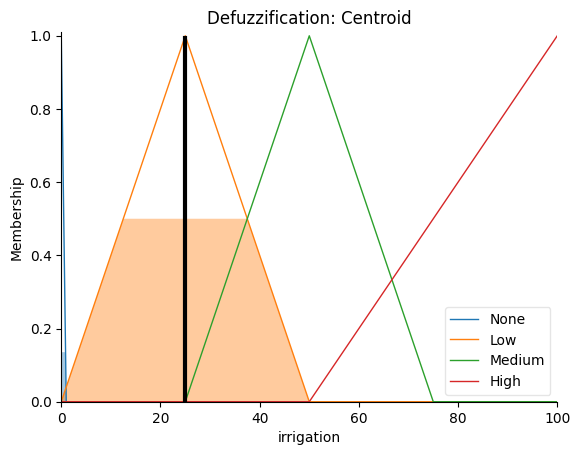

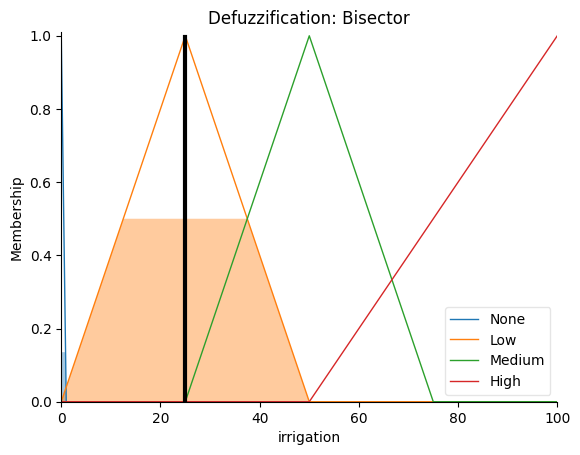

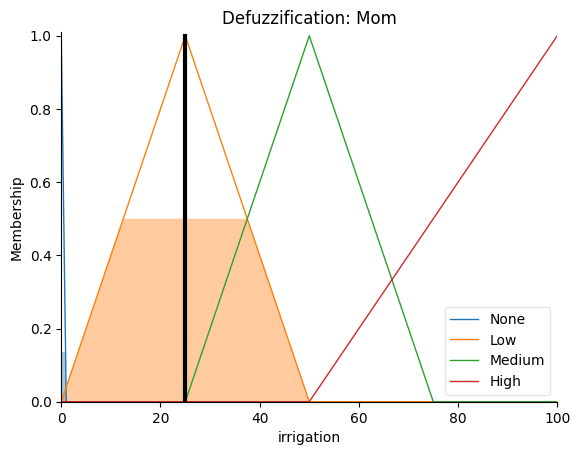

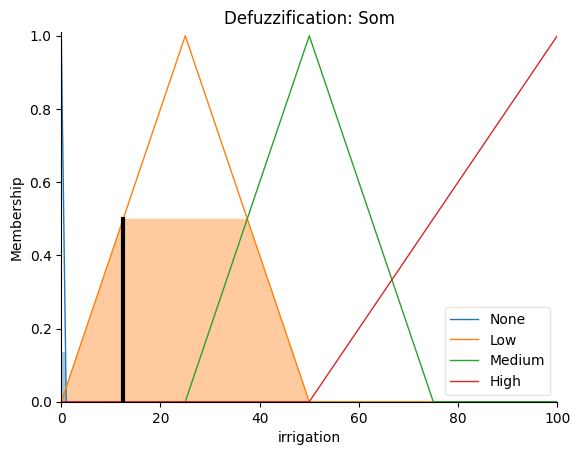

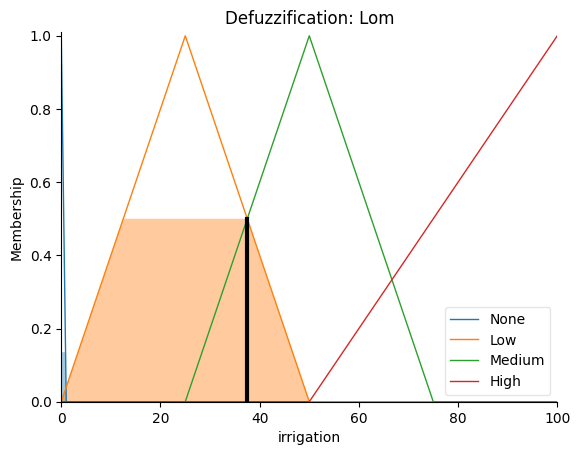

centroid → 24.86
bisector → 24.89
mom      → 25.00
som      → 12.50
lom      → 37.50


In [ ]:
def compare_and_plot(soil_val, weather_label):
    flags = {
        'sunny':  1 if weather_label=='Sunny'  else 0,
        'cloudy': 1 if weather_label=='Cloudy' else 0,
        'rainy':  1 if weather_label=='Rainy'  else 0,
    }

    methods = ['centroid', 'bisector', 'mom', 'som', 'lom']
    results = {}

    for m in methods:
        irrig.defuzzify_method = m
        sim.reset()
        sim.input['soil']   = soil_val
        sim.input['sunny']  = flags['sunny']
        sim.input['cloudy'] = flags['cloudy']
        sim.input['rainy']  = flags['rainy']
        sim.compute()
        results[m] = sim.output['irrigation']

        irrig.view(sim=sim)
        plt.title(f"Defuzzification: {m.capitalize()}")
        plt.show()

    return results

res = compare_and_plot(soil_val=30, weather_label='Rainy')
for method, value in res.items():
    print(f"{method:8s} → {value:.2f}")


### Defuzzification Methods

Comparison of centroid, bisector, mean-of-maxima, smallest/largest-of-maxima methods.

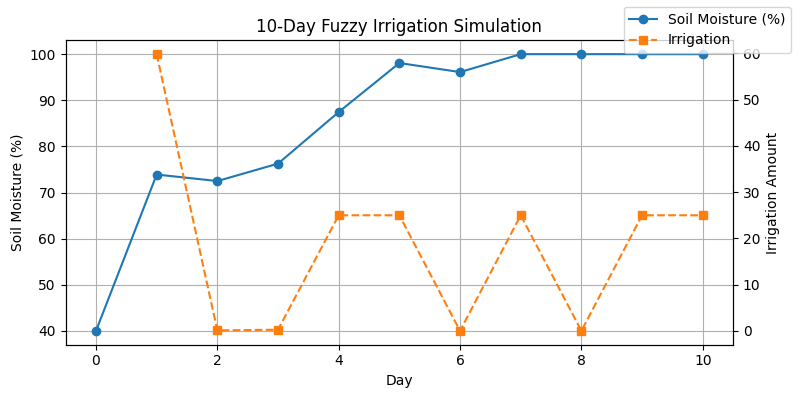

In [ ]:
import random
# RUN A 10-DAY SIMULATION
def simulate_over_time(initial_soil=40.0):
    beta  = 0.6   # irrigation → soil moisture loss
    weather_effects = {
        'Sunny':  -0.05,
        'Cloudy': -0.02,
        'Rainy':  +0.05
    }

    days = np.arange(1, 11)
    weather_seq = ['Sunny']*6 + ['Cloudy']*2 + ['Rainy']*2
    random.shuffle(weather_seq)

    soil_history = [initial_soil]
    irrigation_history = []

    for day, weather in zip(days, weather_seq):
        current_soil = soil_history[-1]
        irrig_amt, _ = compute_irrigation(current_soil, weather)
        irrigation_history.append(irrig_amt)

        next_soil = current_soil + weather_effects[weather]*current_soil + beta*irrig_amt
        next_soil = np.clip(next_soil, 0, 100)

        soil_history.append(next_soil)

    # Plot
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot([0]+list(days), soil_history, 'o-', label='Soil Moisture (%)')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Soil Moisture (%)')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(days, irrigation_history, 's--', color='tab:orange', label='Irrigation')
    ax2.set_ylabel('Irrigation Amount')

    fig.legend(loc='upper right')
    plt.title("10-Day Fuzzy Irrigation Simulation")
    plt.tight_layout()
    plt.show()

 # Run 10-day simulation
simulate_over_time(initial_soil=40.0)

### Temporal Simulation

10-day dynamic simulation with evolving soil moisture and weather patterns.

# Part 2: Advanced Multi-Parameter System

## Enhanced Architecture
Multi-input fuzzy system with continuous environmental variables.

**Inputs**: Soil moisture (5 levels), Rain intensity, Temperature, Crop water requirement  
**Output**: Irrigation amount (5 levels)  
**Features**: Granular classifications, environmental interactions, crop-specific adaptations

## Advanced Variable Definitions

Enhanced membership functions with multi-parameter environmental modeling.

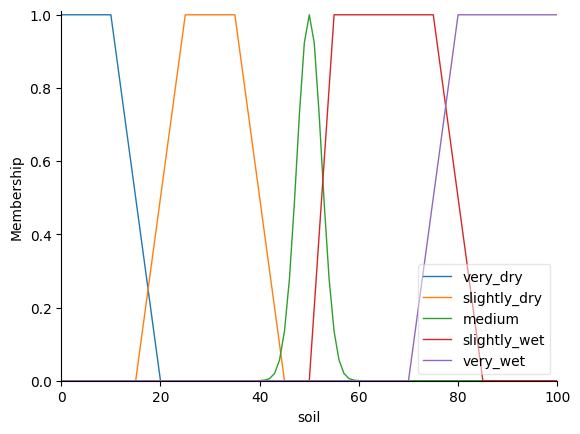

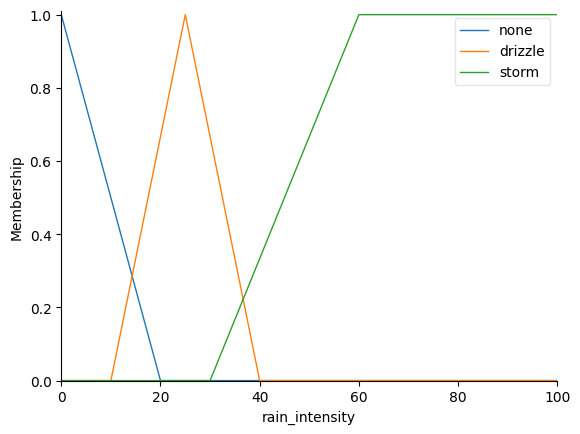

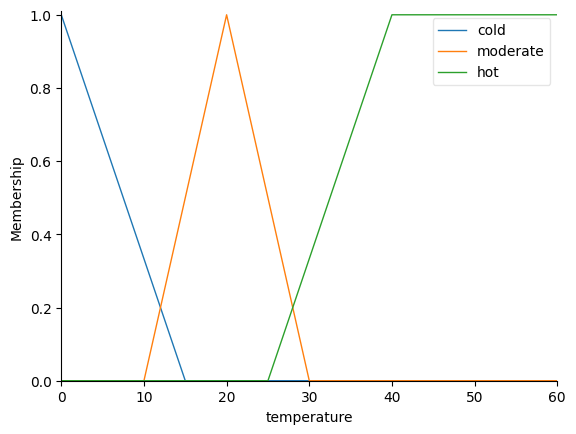

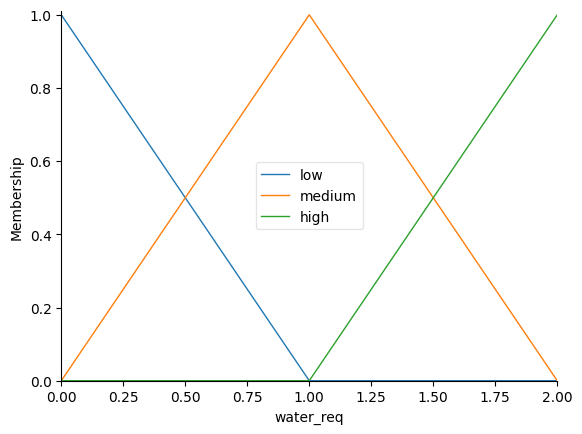

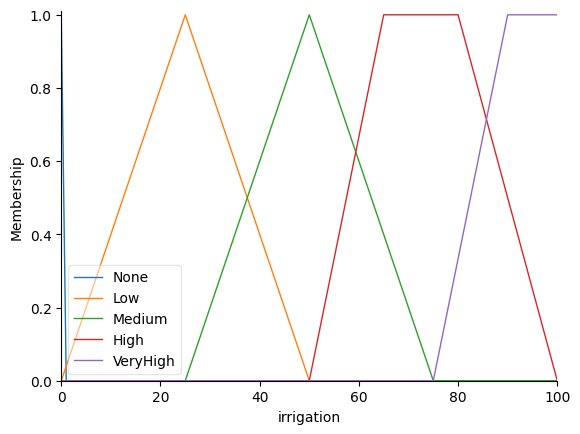

In [ ]:

# Antecedent: soil moisture (0–100)
soil = ctrl.Antecedent(np.arange(0, 101, 1), 'soil')

soil['very_dry']     = fuzz.trapmf(soil.universe, [0,   0, 10, 20])
soil['slightly_dry'] = fuzz.trapmf(soil.universe, [15, 25, 35, 45])
soil['medium']       = fuzz.gaussmf(soil.universe, 50, 2.5)
soil['slightly_wet'] = fuzz.trapmf(soil.universe, [50, 55, 75, 85])
soil['very_wet']     = fuzz.trapmf(soil.universe, [70, 80,100,100])

# Antecedent: rain intensity (0–100)
rain = ctrl.Antecedent(np.arange(0, 101, 1), 'rain_intensity')
rain['none']    = fuzz.trimf(rain.universe, [0,   0,  20])
rain['drizzle'] = fuzz.trimf(rain.universe, [10,  25, 40])
rain['storm']   = fuzz.trapmf(rain.universe, [30,  60, 100, 100])

# Antecedent: temperature (°C, 0–60)
temp = ctrl.Antecedent(np.arange(0, 61, 1), 'temperature')
temp['cold']    = fuzz.trimf(temp.universe, [0,   0,  15])
temp['moderate']= fuzz.trimf(temp.universe, [10,  20, 30])
temp['hot']     = fuzz.trapmf(temp.universe, [25,  40, 60, 60])

# Antecedent: crop water requirement (0–2)
water_req = ctrl.Antecedent(np.arange(0, 3, 1), 'water_req')
water_req['low']    = fuzz.trimf(water_req.universe, [0,   0,  1])
water_req['medium'] = fuzz.trimf(water_req.universe, [0,   1,  2])
water_req['high']   = fuzz.trimf(water_req.universe, [1,   2,  2])

# Consequent: irrigation amount (0–100)
irrig = ctrl.Consequent(np.arange(0, 101, 1), 'irrigation')
irrig['None']     = fuzz.trimf(irrig.universe, [0, 0, 0])
irrig['Low']      = fuzz.trimf(irrig.universe, [0,  25,  50])
irrig['Medium']   = fuzz.trimf(irrig.universe, [25, 50,  75])
irrig['High']     = fuzz.trapmf(irrig.universe, [50,65, 80,100])
irrig['VeryHigh'] = fuzz.trapmf(irrig.universe, [75, 90 ,100,100])


soil.view()
rain.view()
temp.view()
water_req.view()
irrig.view()


## Advanced Rule Base

Complex multi-conditional rules incorporating environmental interactions and crop requirements.

In [ ]:
rules = [
    # Very dry + no rain + hot + high-demand → emergency watering
    ctrl.Rule(soil['very_dry'] & rain['none']    & temp['hot']      & water_req['high'],
         irrig['VeryHigh']),
    ctrl.Rule(soil['very_dry'] & rain['none'] & water_req['high'],
         irrig['VeryHigh']),

    ctrl.Rule(soil['very_dry'] & rain['none'],
         irrig['High']),

    # Very dry + light drizzle → still substantial watering
    ctrl.Rule(soil['very_dry'] & rain['drizzle'] & water_req['medium'],
         irrig['Medium']),

    # Very dry + heavy storm → minimal top-up
    ctrl.Rule(soil['very_dry'] & rain['storm'],
         irrig['Low']),


    # ——— Mild Dryness ———
    # Slightly dry + no rain → high watering
    ctrl.Rule(soil['slightly_dry'] & rain['none'],
         irrig['High']),

    # Slightly dry + drizzle → low watering
    ctrl.Rule(soil['slightly_dry'] & rain['drizzle'],
         irrig['Low']),

    # Slightly dry + storm → skip watering
    ctrl.Rule(soil['slightly_dry'] & rain['storm'],
         irrig['None']),


    # ——— Near–Optimal & Wet ———
    # Medium soil + no rain → medium watering
    ctrl.Rule(soil['medium'] & rain['none'],
         irrig['None']),

    ctrl.Rule(soil['medium'] & rain['none'] & temp['hot'],
         irrig['Low']),

    # Medium soil + any rain → low or none
    ctrl.Rule(soil['medium'] & rain['drizzle'],
         irrig['Low']),
    ctrl.Rule(soil['medium'] & rain['storm'],
         irrig['None']),

     # Slightly wet or very wet → no watering
    ctrl.Rule(soil['slightly_wet'], irrig['None']),
    ctrl.Rule(soil['very_wet'],     irrig['None']),
]


In [ ]:
# CREATE CONTROL SYSTEM & SIMULATOR
system = ctrl.ControlSystem(rules)
simulator = ctrl.ControlSystemSimulation(system)

## Advanced System Testing

Multi-parameter fuzzy inference with complex environmental scenarios.

Irrigation amount → 75.33


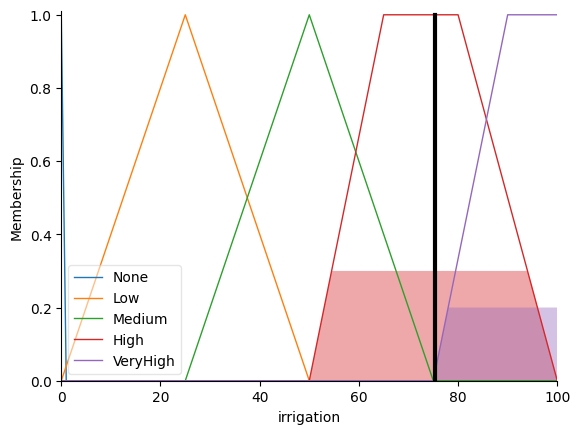

In [ ]:
# Simple one‐off run
simulator.reset()
simulator.input['soil']           = 18    # e.g. “very_dry”
simulator.input['rain_intensity'] = 5     # light drizzle
simulator.input['temperature']    = 28    # warm
simulator.input['water_req']      = 2     # high‐demand crop
simulator.compute()

print(f"Irrigation amount → {simulator.output['irrigation']:.2f}")

# To visualize the aggregated output MF + defuzzification point:
irrig.view(sim=simulator)
plt.show()

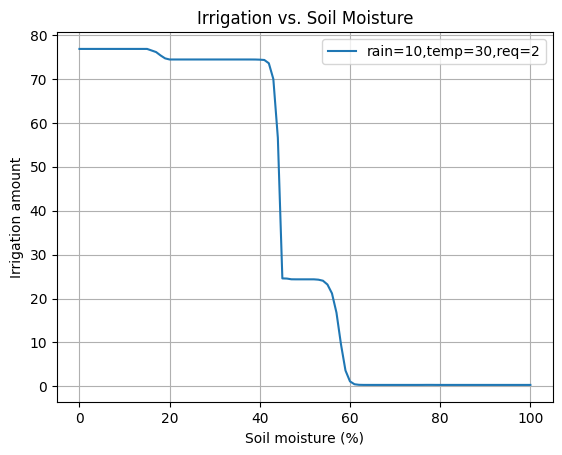

In [ ]:
def compute_irrigation(soil_val, rain_val, temp_val, water_req_val,
                       defuzzify_method='centroid'):
    irrig.defuzzify_method = defuzzify_method

    simulator.reset()
    simulator.input['soil']           = soil_val
    simulator.input['rain_intensity'] = rain_val
    simulator.input['temperature']    = temp_val
    simulator.input['water_req']      = water_req_val

    simulator.compute()
    crisp = simulator.output['irrigation']

    return crisp, simulator


# Sweep soil moisture curve at fixed other inputs
soils      = np.arange(0, 101, 1)
out_curve  = []
for s in soils:
    val, _ = compute_irrigation(s, rain_val=10, temp_val=30, water_req_val=2)
    out_curve.append(val)

plt.figure()
plt.plot(soils, out_curve, label='rain=10,temp=30,req=2')
plt.xlabel('Soil moisture (%)')
plt.ylabel('Irrigation amount')
plt.title('Irrigation vs. Soil Moisture')
plt.legend()
plt.grid(True)
plt.show()

### Advanced Temporal Simulation

Enhanced 10-day simulation with multi-parameter environmental dynamics.

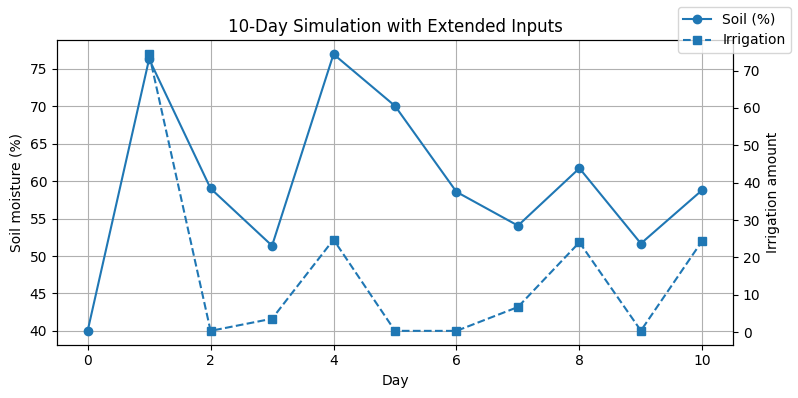

In [ ]:
# 10-day dynamic simulation
def simulate_10_days(initial_soil=40.0,
                     rain_seq=None, temp_seq=None, req=1):
    if rain_seq is None:
        rain_seq = [0, 0, 5, 80, 40 , 10, 0, 0, 10, 0]
    if temp_seq is None:
        temp_seq = [80, 90, 50, 20, 30, 40, 50, 50, 30, 50]

    weather_effects = {
        'Sunny':  -0.05,
        'Cloudy': -0.02,
        'Rainy':  +0.05
    }
    β = 0.6  # irrigation effectiveness
    temp_w = 0.25
    rain_w = 0.5
    days = np.arange(1, 11)
    soil_hist = [initial_soil]
    irrig_hist = []

    for day, (r, t) in enumerate(zip(rain_seq, temp_seq), start=1):
        current = soil_hist[-1]
        irr, _  = compute_irrigation(current, r, t, req)
        irrig_hist.append(irr)

        next_soil = current + (r)*(rain_w) -(t/60)*(temp_w)*current + β*irr

        next_soil = np.clip(next_soil, 0, 100)
        soil_hist.append(next_soil)

    # plot
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot([0]+list(days), soil_hist, 'o-', label='Soil (%)')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Soil moisture (%)')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(days, irrig_hist, 's--', label='Irrigation')
    ax2.set_ylabel('Irrigation amount')

    fig.legend(loc='upper right')
    plt.title("10-Day Simulation with Extended Inputs")
    plt.tight_layout()
    plt.show()


rain_seq = [0, 0, 5, 30, 5 , 0, 0, 0, 0, 0]
temp_seq = [50, 55, 50, 20, 30, 40, 35, 30, 40, 35]
simulate_10_days(initial_soil=40.0, rain_seq=rain_seq, temp_seq=temp_seq, req=1)
